In [1]:
import os
from dotenv import load_dotenv
import requests
import xmltodict, json
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from textwrap import wrap
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer
from collections import defaultdict
import spacy
from spacy.language import Language
from spacy_langdetect import LanguageDetector
#import en_core_web_sm

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\melis\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\melis\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\melis\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\melis\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\melis\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


**<font color='teal'>get api key from .env file</font>**

In [6]:
load_dotenv()
API_KEY = os.getenv('API_KEY')

**<font color='teal'>Use Global Giving's API to access all active projects with respective themes</font>**

In [7]:
# Assign URL to variable: url
url = 'https://api.globalgiving.org/api/public/projectservice/themes/projects/ids?api_key={}'.format(API_KEY)

# Package the request, send the request and catch the response: r
r = requests.get(url)

**<font color='teal'>The response is in xml format, so we will use xmltodict to convert it to a dictionary</font>**

In [8]:
data_dict = xmltodict.parse(r.text)

**<font color='teal'>Next I will take a look at the keys find what will lead me to the themes and the project ID's</font>**

In [9]:
print(data_dict['themes']['theme'][27]['name'])
print(data_dict['themes']['theme'][27]['projects']['project'][430]['id'])

Wildlife Conservation
20480


**<font color='teal'>Next I will use a for loop to get a dictionary with the just the themes and their respective projects. This dictionary will be named "theme_and_proj_id"</font>**

In [10]:
theme_and_proj_id = {}

for i in range(len(data_dict['themes']['theme'])):
    theme = data_dict['themes']['theme'][i]['name']
    project_id_list = []
    for j in range(len(data_dict['themes']['theme'][i]['projects']['project'])):
        project_id_list.append(int(data_dict['themes']['theme'][i]['projects']['project'][j]['id']))
    theme_and_proj_id[theme] = project_id_list

theme_and_proj_id.keys()

dict_keys(['Animal Welfare', 'Child Protection', 'Climate Action', 'Peace and Reconciliation', 'Disaster Response', 'Economic Growth', 'Education', 'Ecosystem Restoration', 'Gender Equality', 'Physical Health', 'Ending Human Trafficking', 'Justice and Human Rights', 'Sport', 'Digital Literacy', 'Food Security', 'Arts and Culture', 'LGBTQIA+ Equality', 'COVID-19', 'Clean Water', 'Disability Rights', 'Ending Abuse', 'Mental Health', 'Racial Justice', 'Refugee Rights', 'Reproductive Health', 'Safe Housing', 'Sustainable Agriculture', 'Wildlife Conservation'])

**<font color='teal'>Next I want to access the summary, challenge, solution, and long term impact of a [project](https://www.globalgiving.org/projects/trees-for-tribes-1/) using Global Giving's API. In the example below, the text is in portuguese and one of the texts is of 'NoneType'. So our data cleaning will take care of these issues as well.</font>**

In [11]:
# Assign URL to variable: url
url = 'https://api.globalgiving.org/api/public/projectservice/projects/39630?api_key=efee163e-82d8-413b-955e-c2dcc7b4bfba'

# Package the request, send the request and catch the response: r
project = requests.get(url)

# Print the text of the response
projectinfo_dict = xmltodict.parse(project.text)
theme = projectinfo_dict['project']['themeName']
longtermimpact = projectinfo_dict['project']['longTermImpact']
challenge = projectinfo_dict['project']['need']
summary = projectinfo_dict['project']['summary']
solution = projectinfo_dict['project']['activities']
title = projectinfo_dict['project']['title']

In [12]:
projectinfo_dict['project']['title']

'Instituto Projeto Esportivo e Sociocultural JB12'

In [13]:
theme

'Animal Welfare'

In [14]:
title

'Instituto Projeto Esportivo e Sociocultural JB12'

In [15]:
summary

'Inovar, motivar e realizar acoes esportivas de cunho humanista, cidadao, socioeducativo e cultural, prioritariamente pelo e para os(a) jovens, na perspectiva de contribuir para que sejam protagonistas de sua propria historia'

In [16]:
challenge

'Inovar, motivar e realizar acoes esportivas de cunho humanista, cidadao, socioeducativo e cultural, prioritariamente pelo e para os(a) jovens, na perspectiva de contribuir para que sejam protagonistas de sua propria historia'

In [17]:
type(solution)

NoneType

In [18]:
longtermimpact

'Inovar, motivar e realizar acoes esportivas de cunho humanista, cidadao, socioeducativo e cultural, prioritariamente pelo e para os(a) jovens, na perspectiva de contribuir para que sejam protagonistas de sua propria historia'

**<font color='teal'>Here I will combine the title, summary, challenge, and solution into one long text, which I will clean and get ready for NLP</font>**

In [19]:
text_list = [title, summary, challenge, solution, longtermimpact]

#filter list of texts for those that contain strings
text = ''.join(filter(lambda x: x if x is not None else '', text_list))

#lowercase the text
text=text.lower()

#remove numbers
text = ''.join([i for i in text if not i.isdigit()])

#replace hyphens with spaces
text = text.replace('-', ' ')

#remove punctuation
punct = string.punctuation
text = text.translate(str.maketrans('','', punct))

#remove extra spaces
text = " ".join(text.split())

#remove stopwords
stop_words = set(stopwords.words('english')) 

# Tokenize the sentence
words = word_tokenize(text)
filtered_list = []
for w in words:
    if w.lower() not in stop_words:
        filtered_list.append(w)
text = " ".join(filtered_list)

#Use lemmatization
tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

tokens = word_tokenize(text)
lemma_function = WordNetLemmatizer()
lemma_list = []
for token, tag in pos_tag(tokens):
    lemma = lemma_function.lemmatize(token, tag_map[tag[0]])
    lemma_list.append(lemma)
    
text = " ".join(lemma_list)
text

'instituto projeto esportivo e sociocultural jbinovar motivar e realizar acoes esportivas de cunho humanista cidadao socioeducativo e cultural prioritariamente pelo e para osa jovens na perspectiva de contribuir para que sejam protagonistas de sua propria historiainovar motivar e realizar acoes esportivas de cunho humanista cidadao socioeducativo e cultural prioritariamente pelo e para osa jovens na perspectiva de contribuir para que sejam protagonistas de sua propria historiainovar motivar e realizar acoes esportivas de cunho humanista cidadao socioeducativo e cultural prioritariamente pelo e para osa jovens na perspectiva de contribuir para que sejam protagonistas de sua propria historia'

**<font color='teal'>The function below detects the language of the text, which is portuguese</font>**

In [20]:
def get_lang_detector(nlp, name):
    return LanguageDetector()

nlp = spacy.load('en_core_web_sm')
Language.factory("language_detector", func=get_lang_detector)
nlp.add_pipe('language_detector', last=True)

In [21]:
doc = nlp(text)
lang_dict = doc._.language
lang_dict

{'language': 'pt', 'score': 0.9999958725599972}

**<font color='teal'>Next, I will combine the steps above into a function that takes in a project URL and outputs clean text. Another functional also detects the language of the text. Later on, I will determine how many of the projects are not in English. If there isn't a lot of them, they can be removed from the dataset.</font>**

In [22]:
def get_clean_text(url):
    # Package the request, send the request and catch the response: r
    project = requests.get(url)

    # conver the response to a dictionary
    projectinfo_dict = xmltodict.parse(project.text)
    
    #gather the theme, longtermimpact, summary, challenge, and solution. 
    #If they are not present, set these variables equal to an empty string
    try:
        theme = projectinfo_dict['project']['themeName']
    except KeyError:
        theme = ''
    try:
        longtermimpact = projectinfo_dict['project']['longTermImpact']
    except KeyError:
        longtermimpact = ''
    try:
        challenge = projectinfo_dict['project']['need']
    except KeyError:
        challenge = ''
    try:
        summary = projectinfo_dict['project']['summary']
    except KeyError:
        summary = ''
    try:
        solution = projectinfo_dict['project']['activities']
    except KeyError:
        solution = ''
    try:
        title = projectinfo_dict['project']['title']
    except KeyError:
        title = ''
    
    text_list = [title, summary, challenge, solution, longtermimpact]

    #filter list of texts for those that contain strings
    text = ''.join(filter(lambda x: x if x is not None else '', text_list))

    #lowercase the text
    text=text.lower()

    #remove numbers
    text = ''.join([i for i in text if not i.isdigit()])

    #replace hyphens with spaces
    text = text.replace('-', ' ')

    #remove punctuation
    punct = string.punctuation
    text = text.translate(str.maketrans('','', punct))

    #remove extra spaces
    text = " ".join(text.split())

    #remove stopwords
    stop_words = set(stopwords.words('english')) 

    # Tokenize the sentence
    words = word_tokenize(text)
    filtered_list = []
    for w in words:
        if w.lower() not in stop_words:
            filtered_list.append(w)
    text = " ".join(filtered_list)

    #Use lemmatization
    tag_map = defaultdict(lambda : wn.NOUN)
    tag_map['J'] = wn.ADJ
    tag_map['V'] = wn.VERB
    tag_map['R'] = wn.ADV

    tokens = word_tokenize(text)
    lemma_function = WordNetLemmatizer()
    lemma_list = []
    for token, tag in pos_tag(tokens):
        lemma = lemma_function.lemmatize(token, tag_map[tag[0]])
        lemma_list.append(lemma)

    text = " ".join(lemma_list)
    return text

**<font color='teal'>Here I will randomly select 20 projects from the following themes: COVID-19, disaster response, climate action, education, and gender equality. Then I will use the function I just created to extract and clean the text for each project</font>**

In [23]:
popular_themes = ['COVID-19','Disaster Response','Climate Action','Education','Gender Equality']

project_ids = []
themes = []
texts = []

for theme in popular_themes:
    IDs = random.sample(theme_and_proj_id[theme],20)
    for ID in IDs:
        themes.append(theme)
        project_ids.append(ID)
        url = 'https://api.globalgiving.org/api/public/projectservice/projects/{}?api_key={}'.format(str(ID),API_KEY)
        text = get_clean_text(url)
        texts.append(text)

**<font color='teal'>The next step is to use the bag-of-words model to count the words in each of the texts. This will also be organized in Pandas DataFrame.</font>**

In [24]:
count_vect = CountVectorizer()
counts = count_vect.fit_transform(texts)
bw = pd.DataFrame(counts.toarray(),columns=count_vect.get_feature_names(),index=project_ids)
bw['theme'] = themes

C:\Users\melis\Envs\topic_classification\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


**<font color='teal'>Here I will look at the most common words for each theme</font>**

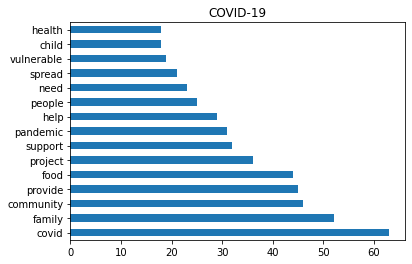

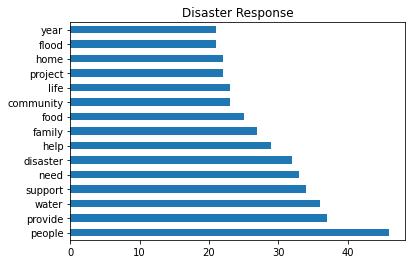

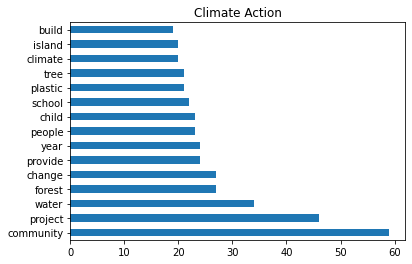

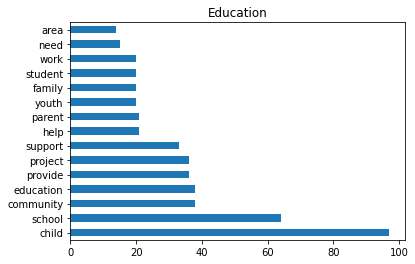

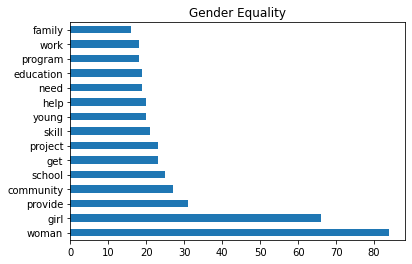

In [25]:
grouped_bw = bw.groupby('theme').sum()
for theme in popular_themes:
    theme_df = grouped_bw.loc[theme].sort_values(ascending = False)
    most_common_words = grouped_bw.loc[theme].sort_values(ascending = False).index[:15]
    fig, ax = plt.subplots()
    theme_df[most_common_words].plot.barh()
    ax.set_title(theme)
    plt.show()

In [26]:
vectorizer = TfidfVectorizer()
trsfm=vectorizer.fit_transform(texts)
tfid = pd.DataFrame(trsfm.toarray(),columns=vectorizer.get_feature_names(),index=project_ids)
tfid

C:\Users\melis\Envs\topic_classification\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,aai,abandon,abide,ability,able,abroad,absence,abuja,abundance,abuse,...,young,youngster,youth,youthfarming,youthour,youths,youthssam,zakat,zero,zone
49115,0.0,0.0,0.0,0.0,0.050232,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
45980,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
46354,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0000,0.0,0.0,0.0,0.0,0.000000,0.079075,0.0
50449,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
51690,0.0,0.0,0.0,0.0,0.041551,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0000,0.0,0.0,0.0,0.0,0.076577,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30387,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
19369,0.0,0.0,0.0,0.0,0.080879,0.000000,0.0,0.0,0.0,0.035691,...,0.000000,0.0,0.0000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
23614,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.051867,...,0.083398,0.0,0.0000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
8758,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.196322,0.0,0.1111,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0


**<font color='teal'>Since it didn't take long to obtain 20 projects for the most popular themes, now I will attempt to get all the projects and organize this into a .csv file that will contain the project_id, the text, the theme, and the language, and whether they are active projects or not.</font>**

In [ ]:
themes = theme_and_proj_id.keys()

project_ids = []
texts = []
languages = []
active = []
theme_list = []

for theme in themes:
    IDs = theme_and_proj_id[theme]
    theme_list.append(theme)
    for ID in IDs:
        project_ids.append(ID)
        url = 'https://api.globalgiving.org/api/public/projectservice/projects/{}?api_key={}'.format(str(ID),API_KEY)
        url_dict = xmltodict.parse(project.text)
        status = url_dict['project']['active']
        theme_list.append(theme)
        active.append(status)
        text = get_clean_text(url)
        texts.append(text)
        doc = nlp(text)
        lang_dict = doc._.language
        languages.append(lang_dict['language'])

In [130]:
df = pd.DataFrame({'project_id':project_ids, 'active': active, 'language': languages, 'text':texts})
df.to_csv('../data/raw/data.csv')